In [1]:
import torch
import pandas as pd 
import numpy as np
from transformer import VanillaTimeSeriesTransformer_EncoderOnly, VanillaTimeSeriesTransformer
from utils import Trainer, preprocess_data, seed_everything
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import pickle 


seed_everything()

In [2]:
class ModelTrainingManager:
    
    def __init__(self, model_name, df_path, best_path, top_features_num, input_len, next_ith, top_features_path='../data/top_feattures.pkl',
                 batch_size=256, num_epochs=100, early_stopping_patience_limit=10, device='cuda:3', 
                 model_file_path="models/best_model.pt", is_save_model=True, is_plot=True, is_plot_and_plot_test=False):
        
        self.model_name = model_name
        self.df_path = df_path
        self.best_path = best_path
        self.top_features_num = top_features_num
        self.input_len = input_len
        self.next_ith = next_ith
        self.top_features_path = top_features_path
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.early_stopping_patience_limit = early_stopping_patience_limit
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model_file_path = model_file_path
        self.is_save_model = is_save_model
        self.is_plot = is_plot
        self.is_plot_and_plot_test = is_plot_and_plot_test

    def preprocess_data(self):
        self.df = pd.read_csv(self.df_path)
        with open(self.top_features_path, 'rb') as file:
            top_feattures = pickle.load(file)
        top_feattures = top_feattures[:self.top_features_num]
        top_feattures.append('close')
        self.df = self.df[top_feattures]
        
        # preprocessing filtered df
        self.scaled_df, _, self.scaler_close, self.train_dataloader, self.val_dataloader, self.test_dataloader = preprocess_data(
            self.df, batch_size=self.batch_size, input_seq_len=self.input_len, output_seq_len=self.next_ith)

    def load_model(self):
        with open(self.best_path, 'rb') as file:
            self.best = pickle.load(file)

        # assigning model's hyperparameters based on the tuning
        model_params = {
            "num_features": int(len(self.scaled_df.columns)),
            "num_layers": int(self.best["num_layers"]),
            "num_heads": int(self.best["num_heads"]),
            "d_model": int(self.best['d_model_by_num_heads']) * int(self.best["num_heads"]),
            "dff": int(self.best['dff']),
            "mlp_size": int(self.best['mlp_size']), # size of the first MLP layer
            "dropout_rate": round(self.best['dropout_rate'], 3),  # dropout rate for the Transformer layers
            "mlp_dropout_rate": round(self.best['mlp_dropout_rate'], 3) # dropout rate for the MLP layers
        }

        # instantiating model itself
        self.model = eval(self.model_name)(**model_params)
        self.model = self.model.to(self.device)


    def compile_and_train(self):
        self.criterion = MSELoss() 
        self.optimiser = Adam(self.model.parameters(), lr=round(self.best['lr'], 6))
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimiser, 'min', factor=0.9, patience=5)

        # declaring trainer object
        self.model_trainer = Trainer(model=self.model,
                            train_dataloader=self.train_dataloader,
                            val_dataloader=self.val_dataloader,
                            test_dataloader=self.test_dataloader,
                            criterion=self.criterion,
                            optimiser=self.optimiser,
                            scheduler=self.scheduler,
                            device=self.device,
                            num_epochs=self.num_epochs,
                            early_stopping_patience_limit=self.early_stopping_patience_limit,
                            is_save_model=self.is_save_model,
                            scaler=self.scaler_close,
                            file_path = self.model_file_path)
        # training
        self.train_losses, self.val_losses = self.model_trainer.train_loop(is_plot=self.is_plot, 
                                                                           is_plot_and_plot_test=self.is_plot_and_plot_test)

    def test(self):
        # testing
        self.mse, self.mae = self.model_trainer.test_model()

    def run_training_testing(self):
        self.preprocess_data()
        self.load_model()
        self.compile_and_train()
        self.test()


# Vanilla Transformer - Encoder Only

#### Close Column Only (Input: last 96 data points, Output: the next first future data)

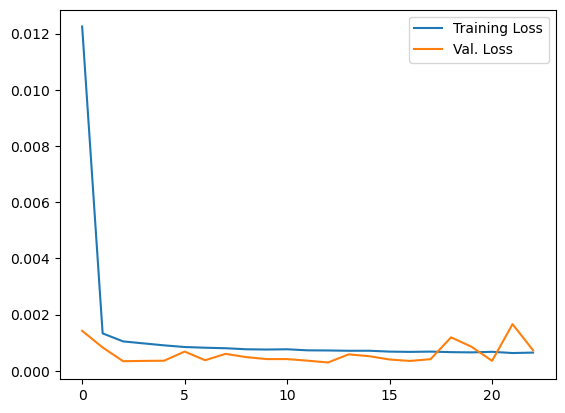

Current MAE 0.02174846744417038
Best MAE 0.012512861521131804
Early stopping triggered
Test MSE: 700792.8125, Test MAE: 601.8746948242188


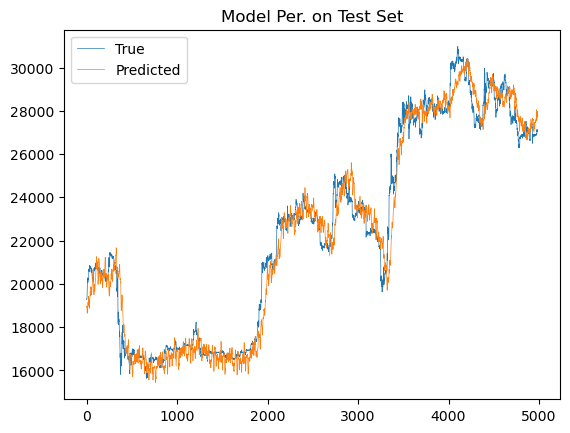

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_1.pt").run_training_testing()

#### Top 2 Features (Input: last 96 data points, Output: the next first future data)

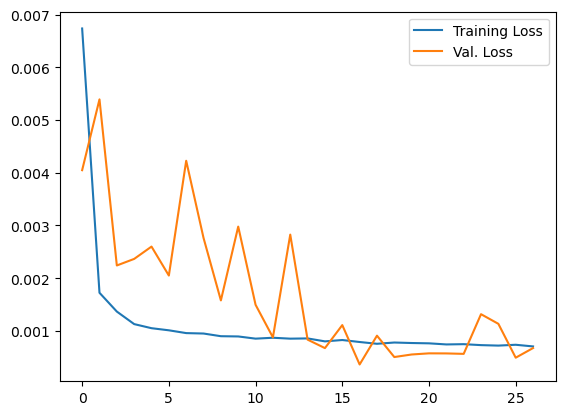

Current MAE 0.02196412134089824
Best MAE 0.014164168170093742
Early stopping triggered
Test MSE: 1965491.875, Test MAE: 1167.163330078125


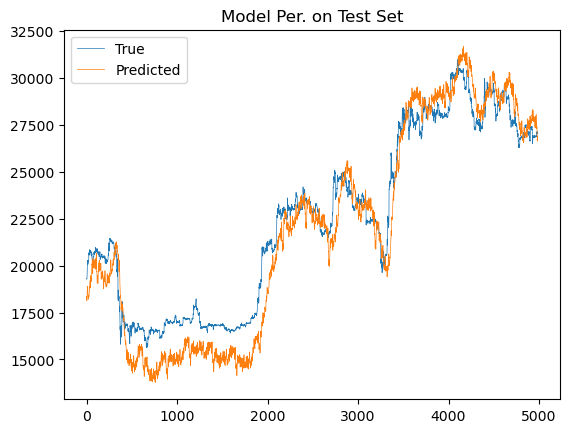

In [4]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=2, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&2_col_best_model_96_1.pt").run_training_testing()

#### Top 5 Features (Input: last 96 data points, Output: the next first future data)

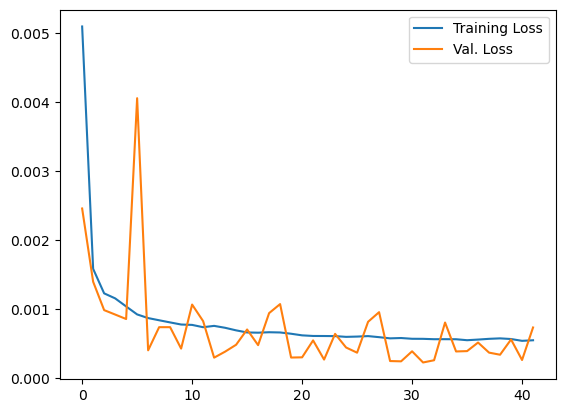

Current MAE 0.024237377675569643
Best MAE 0.011134839957951751
Early stopping triggered
Test MSE: 1367418.375, Test MAE: 924.1824340820312


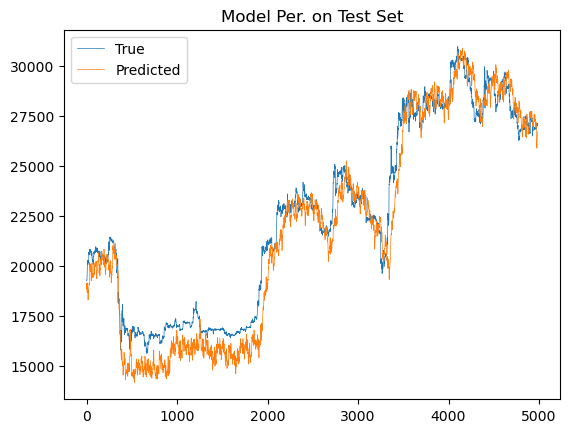

In [5]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=5, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&5_col_best_model_96_1.pt").run_training_testing()

#### Top 10 Features (Input: last 96 data points, Output: the next first future data)

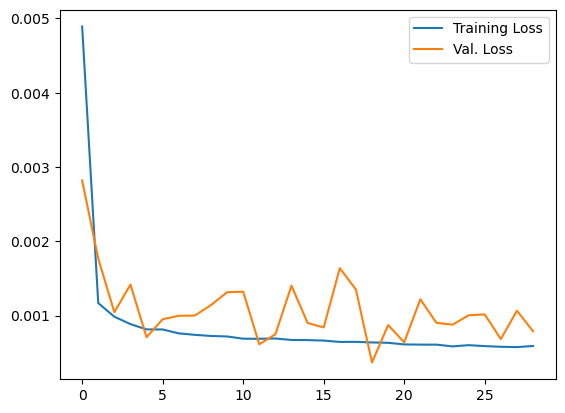

Current MAE 0.02199666994019461
Best MAE 0.01536022093083519
Early stopping triggered
Test MSE: 10513656.0, Test MAE: 3070.07763671875


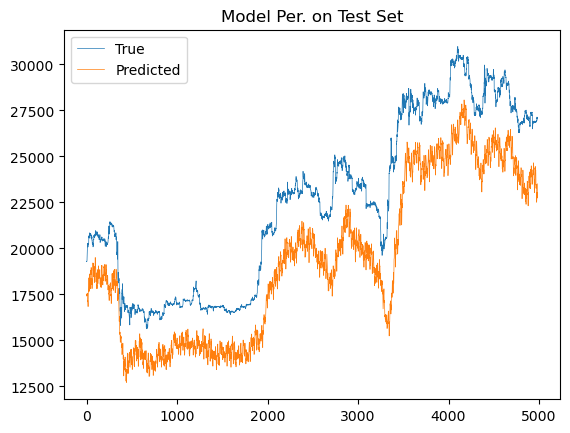

In [6]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close&10_col_best_model_96_1.pt").run_training_testing()

#### Selected Top Features (Input: last 96 data points, Output: the next 12th future data)

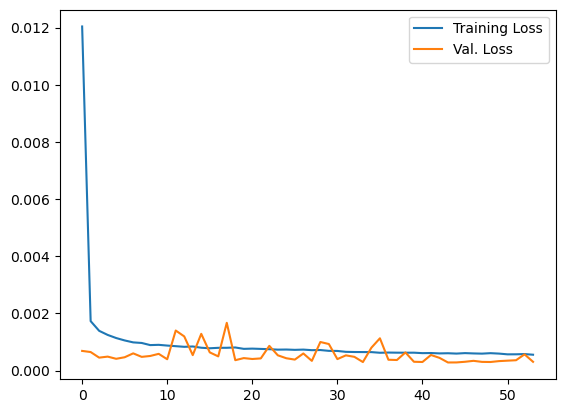

Current MAE 0.013116137739001844
Best MAE 0.012041635226823067
Early stopping triggered
Test MSE: 709833.0, Test MAE: 592.0399169921875


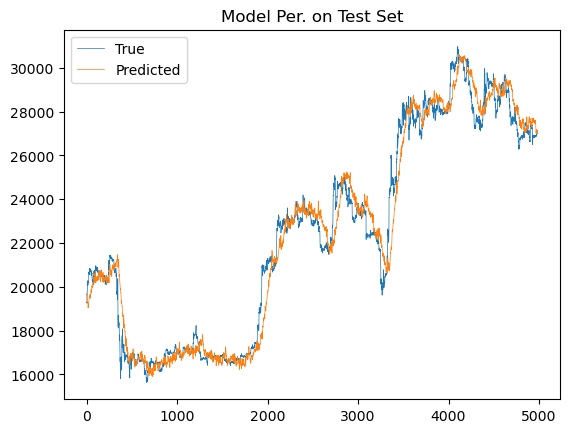

In [7]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_96_12.pt").run_training_testing()

#### Selected Top Features (Input: last 192 data points, Output: the next 24th future data)

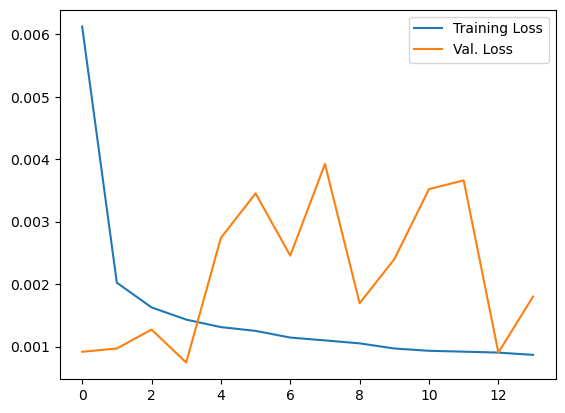

Current MAE 0.03574165804893359
Best MAE 0.018869007946962654
Early stopping triggered
Test MSE: 2045428.375, Test MAE: 1130.0472412109375


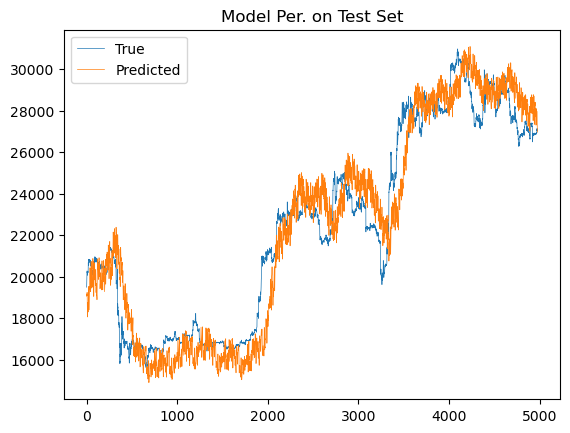

In [8]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer_EncoderOnly",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_hourly.pkl",
    top_features_num=0, 
    input_len=192, 
    next_ith=24,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_only_close_col_best_model_192_24.pt").run_training_testing()

# Vanilla Transformer - Encoder Decoder (Teacher Forcing)

#### Close Column Only (Input: last 96 data points, Output: the next first future data)

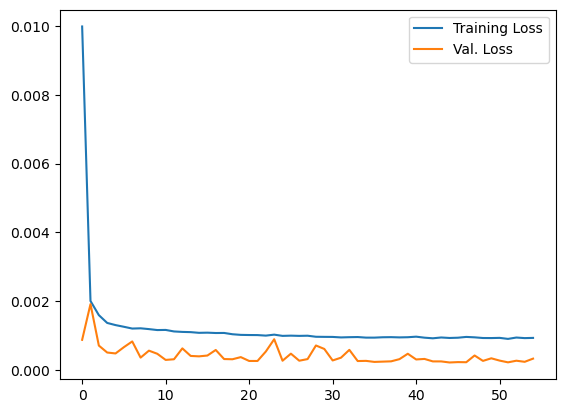

Current MAE 0.014417901426112819
Best MAE 0.011059175420612277
Early stopping triggered
Test MSE: 837128.5625, Test MAE: 707.2738647460938


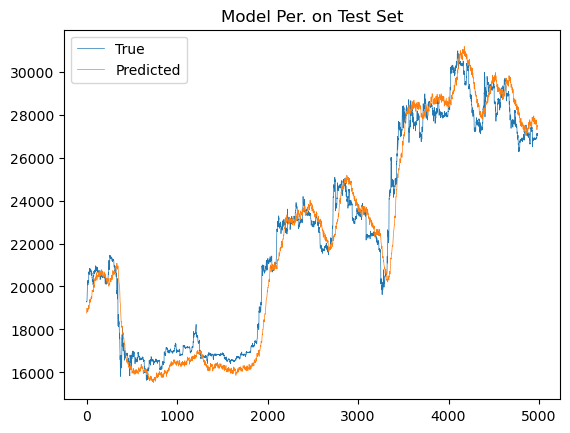

In [9]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_1.pt").run_training_testing()

#### Top 2 Features (Input: last 96 data points, Output: the next first future data)

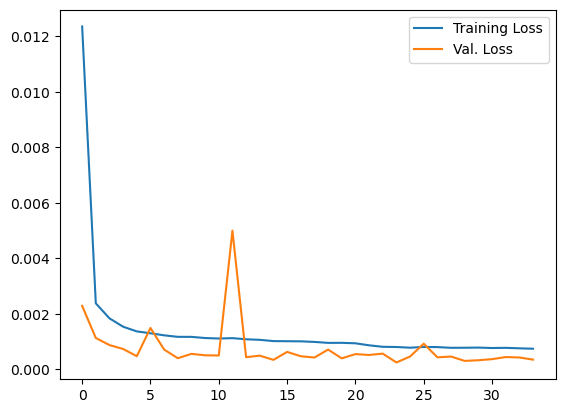

Current MAE 0.014061418952515635
Best MAE 0.011528132404896656
Early stopping triggered
Test MSE: 1288343.25, Test MAE: 862.7518310546875


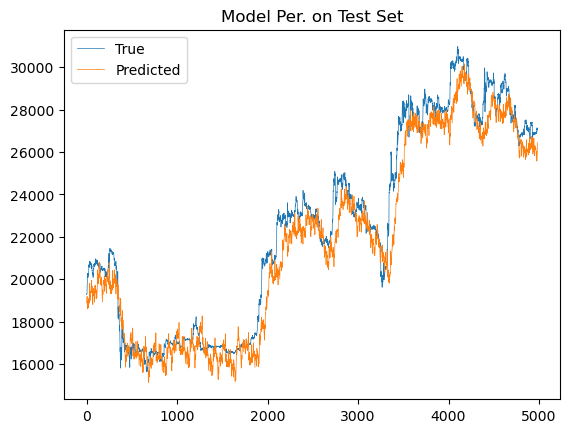

In [10]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=2, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&2_col_best_model_96_1.pt").run_training_testing()

#### Top 5 Features (Input: last 96 data points, Output: the next first future data)

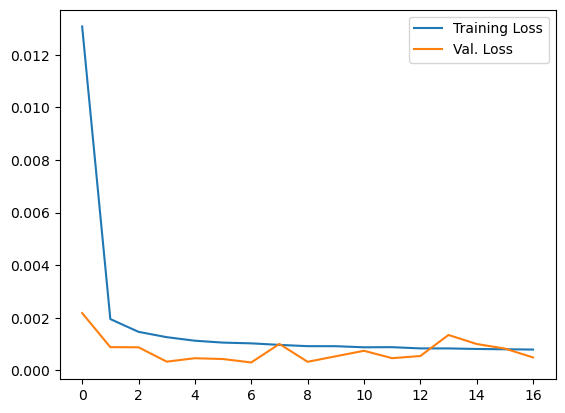

Current MAE 0.01668896646086601
Best MAE 0.013941145640281342
Early stopping triggered
Test MSE: 3557254.5, Test MAE: 1659.9927978515625


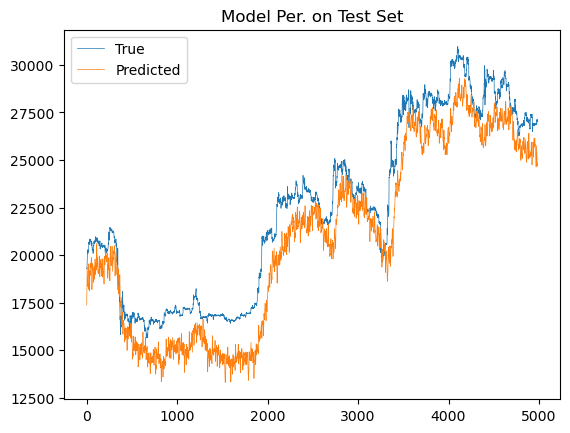

In [11]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=5, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&5_col_best_model_96_1.pt").run_training_testing()

#### Top 10 Features (Input: last 96 data points, Output: the next first future data)

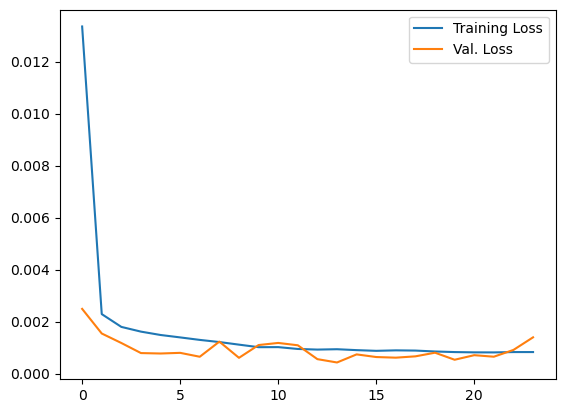

Current MAE 0.03390111722493004
Best MAE 0.016058783716295166
Early stopping triggered
Test MSE: 7680367.5, Test MAE: 2595.271484375


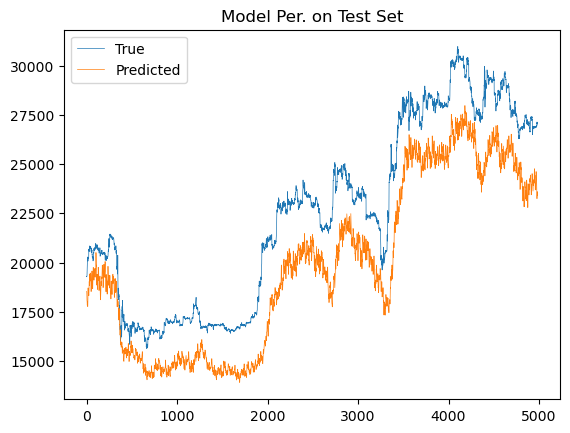

In [12]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=10, 
    input_len=96, 
    next_ith=1,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close&10_col_best_model_96_1.pt").run_training_testing()

#### Selected Top Features (Input: last 96 data points, Output: the next 12th future data)

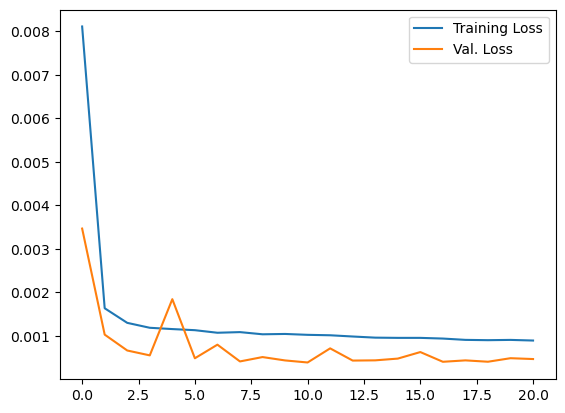

Current MAE 0.015692572056332284
Best MAE 0.014764843107968042
Early stopping triggered
Test MSE: 1315068.75, Test MAE: 897.0918579101562


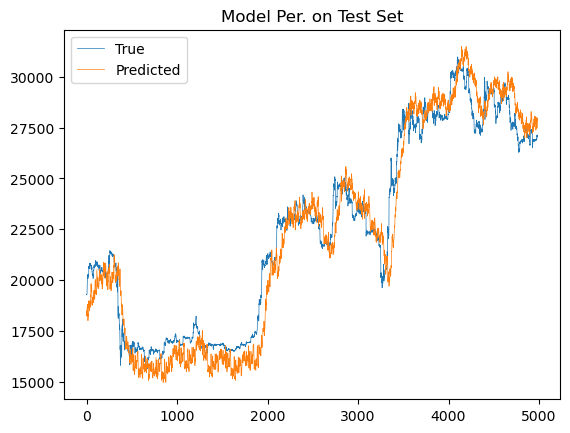

In [3]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=96, 
    next_ith=12,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_96_12.pt").run_training_testing()

#### Selected Top Features (Input: last 192 data points, Output: the next 24th future data)

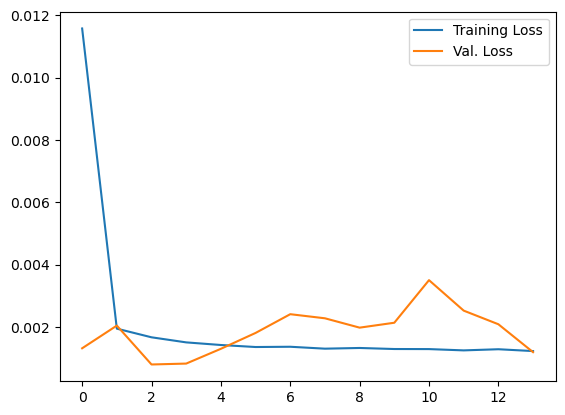

Current MAE 0.02508931489128991
Best MAE 0.020144657537413693
Early stopping triggered
Test MSE: 2698210.5, Test MAE: 1307.4737548828125


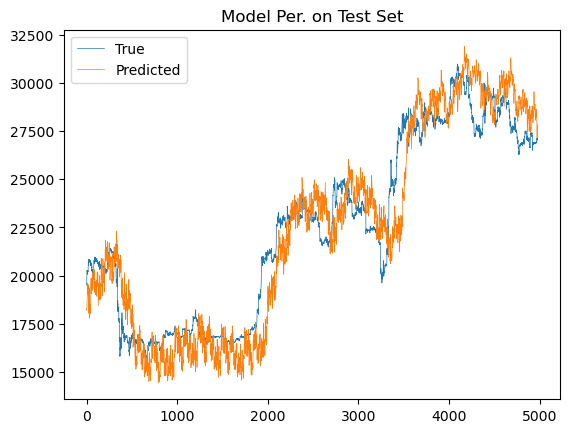

In [14]:
ModelTrainingManager(model_name="VanillaTimeSeriesTransformer",
    df_path="../data/Final_data_hourly.csv",
    best_path="../data/best_on_hyperparam_for_top_Feature_Combo_vanilla_transformer_w_decoder_hourly.pkl",
    top_features_num=0, 
    input_len=192, 
    next_ith=24,
    top_features_path='../data/top_feattures.pkl',
    model_file_path="models/transformer_enc_dec_close_col_best_model_192_24.pt").run_training_testing()